# Exploring precipitation, runoff, and ratios

A Jupyter notebook by Peter Donovan. Please email me (managingwholes.com@gmail.com) with questions or suggestions and pull requests. I would like to keep this relatively simple for accessibility and use.

Precipitation: rainfall gauges using the Applied Climate Information System (NOAA), plus CHIRPS using Google Earth Engine: *Climate Hazards Group InfraRed Precipitation with Station data (CHIRPS) is a 30+ year quasi-global rainfall dataset. CHIRPS incorporates 0.05° resolution satellite imagery with in-situ station data to create gridded rainfall time series for trend analysis and seasonal drought monitoring.*

*Runoff ratio* is the ratio of runoff to precipitation, or the fraction of precipitation received that runs off. For a watershed, can we track change over time from stream gauge and precipitation data? Trends in runoff ratios may be an indication of overall soil function, compaction, etc.

Streamflow gauges: mostly USGS, be alert for other sources. Sometimes state agencies have taken over USGS gauges and data presentation (e.g. some places in Oregon). 

The climata library handles HUC8 watershed codes well (not HUC6). Arrays of HUC8 codes can also be used.

For me in this notebook, geojson for watershed boundaries is perhaps most easily retrieved using Google Earth, using the EPA "Waters of the US" streaming layer. At the appropriate zoom level, HUC8 (8-digit code) boundaries can be seen. Right-click the feature in the left-hand Places window to copy the kml, then paste it into https://mapbox.github.io/togeojson/ and copy the result into a local file. You can get the acreage by clicking on the feature in Google Earth.



In [1]:
#basic imports. The climata library is from http://climata.houstoneng.net/
from climata.usgs import DailyValueIO
from climata.acis import StationDataIO
import hydrofunctions as hf
import datetime
import pandas as pd, numpy as np
import folium  #folium on Jupyter doesn't display well in Microsoft Edge. Chrome works.
# import vincent, vega #for charting in popups
# vincent.core.initialize.notebook()
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8] #gives size in inches to plots
%matplotlib inline


## Set parameters
such as a HUC8 code (8-digit hydrologic unit code). Not all HUC8 watersheds are "complete" but some are divided into upper and lower. As mentioned, the EPA "Waters of the US" streaming layer for Google Earth is an easy interface for exploring watershed boundaries.

In [81]:
shed = '17120002' #climata library does HUC8 (8-digit) watershed units OR an array of them.
shedName='Silvies'
acres= 843709

#might as well explore data for a longer period. Can always reduce date range depending on data availability
startdate = '1919-01-01' 
enddate = '2019-07-29'
param_id = "pcpn" # = precip in inches


## Flashiness
is the variability, and in this case we are dealing with daily values of streamflow and precipitation.

In [7]:
def flashiness(series):
    """Richards-Baker Flashiness Index for a Pandas series of daily mean flows = the path length divided by the sum. WARNING: if the sum is zero (for example in a precipitation record with missing records replaced with zeros) this will result in an error."""
    Qsum = np.sum(series)  # sum of daily flows
    # the path length, or sum of differences between adjacent daily flows:
    Qpath = np.sum(pd.Series(np.abs(series.shift(1)-series))) 
    if Qsum == 0:
        return 0
    else:    
        return round(Qpath/Qsum,2)

    
# some styling for huc8 borders
    
def huc8_borders(feature):
    return {
        'fillOpacity': 0,
        'weight': 2,
        'color':'red'
        }

def huc12_borders(feature):
    return {
        'fillOpacity': 0,
        'weight': 1,
        'color':'blue'
        }


# Precipitation

In [82]:
#what are available precipitation gauges in the basin for our date range?
startdate = '1981-10-01'
pdata = StationDataIO(
    start_date=startdate,
    end_date=enddate,
    basin=shed,
    parameter=param_id,
)
list(pdata) 

[StationDataIOTuple(name='SNOW MOUNTAIN', sids={'GHCN': 'USS0019F01S'}, county='41025', state='OR', elev=6230.0, climdiv='OR07', uid=67633, longitude=-119.54, latitude=43.95, data=<climata.acis.DataIO object at 0x000001AFE8EB3668>),
 StationDataIOTuple(name='SENECA', sids={'COOP': '357675', 'GHCN': 'USC00357675', 'NWSLI': 'SENO3'}, county='41023', state='OR', elev=4660.0, climdiv='OR08', uid=15220, longitude=-118.975, latitude=44.1383, data=<climata.acis.DataIO object at 0x000001AFE8EB3F98>),
 StationDataIOTuple(name='STARR RIDGE', sids={'GHCN': 'USS0019E07S'}, county='41023', state='OR', elev=5250.0, climdiv='OR08', uid=67632, longitude=-119.02, latitude=44.26, data=<climata.acis.DataIO object at 0x000001AFED32A198>),
 StationDataIOTuple(name='CANYON CITY 12.6 SSW', sids={'GHCN': 'US1ORGR0004', 'CoCoRaHS': 'ORGR0004'}, county='41023', state='OR', elev=4799.0, climdiv='OR08', uid=68168, longitude=-119.09, latitude=44.24, data=<climata.acis.DataIO object at 0x000001AFED32A160>)]

In [83]:
# create a dataframe of precipitation records called p
for i in range(0,len(pdata)):
    if i==0:
        dates = [r[0] for r in pdata[i].data]
        pcpn = [r[1] for r in pdata[i].data]
        p = pd.DataFrame(data = pcpn, columns = [pdata[i].name], index=dates)
    else:
        p[pdata[i].name] = [r[1] for r in pdata[i].data]
#make sure it's a datetime index
p.index = pd.to_datetime(p.index)
p.describe()

,SNOW MOUNTAIN,SENECA,STARR RIDGE,CANYON CITY 12.6 SSW
count,13816.0,13816.0,13816.0,13816
unique,21.0,108.0,17.0,79
top,0.0,0.0,0.0,M
freq,9686.0,8829.0,10192.0,11519


array([<matplotlib.axes._subplots.AxesSubplot object at 0x000001AF885DDA90>,
      dtype=object)

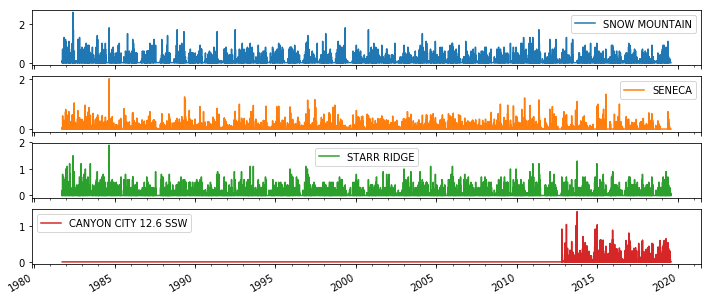

In [84]:
#replace text values so they can be plotted
p.replace(to_replace = ['M','T','S','A'], value=0, regex=True, inplace=True)
#plot each gauge with enough vertical height to read
p.plot(subplots=True, figsize=(12,len(pdata)*1.3))

In [85]:
#NOW CHOOSE the best precipitation stations to use with most complete data
bestgauges = ['SENECA']
#p is the actual precip data
p=p[bestgauges]
#basic stations dataframe for mapping etc.
pstations = pd.DataFrame([[y for y in x] for x in pdata],
columns=['name','codes','county','st','r','a','b','lon','lat','data'])

#filter the pstations dataframe and map these
pstations = pstations.loc[pstations['name'].isin(bestgauges)]
m = folium.Map(location=[pstations['lat'].mean(), pstations['lon'].mean()], zoom_start=9, tiles="Stamen Terrain")
for i in range(0,len(pstations)):
    tooltip = pstations.iloc[i]['name']
    folium.Marker([pstations.iloc[i]['lat'], pstations.iloc[i]['lon']],tooltip=tooltip).add_to(m)

#include the HUC8 boundaries downloaded from Google Earth and converted by https://mapbox.github.io/togeojson/
folium.GeoJson('C:/Users/Peter/Documents/atlas/notebooks/geojson/silvies.geojson',
    name='HUC8 boundaries',
    style_function=huc8_borders,
    ).add_to(m)
    
m

In [16]:
p.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 42734 entries, 1902-01-01 to 2018-12-31
Data columns (total 3 columns):
SENECA            42734 non-null float64
SNOW MOUNTAIN     42734 non-null float64
BURNS WSO CITY    42734 non-null float64
dtypes: float64(3)
memory usage: 1.3 MB


In [86]:
p

,SENECA
1981-10-01,0.00
1981-10-02,0.03
1981-10-03,0.00
1981-10-04,0.00
1981-10-05,0.00
1981-10-06,0.08
1981-10-07,0.01
1981-10-08,0.00
1981-10-09,0.01
1981-10-10,0.09


In [87]:
#here's where we decide the water year with grouping using Grouper. 3-letter abbrev for ending month
pgroup = p.groupby(pd.Grouper(freq='A-SEP')).agg({np.sum})
pgroup.columns = bestgauges
pgroup.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 38 entries, 1982-09-30 to 2019-09-30
Freq: A-SEP
Data columns (total 1 columns):
SENECA    38 non-null float64
dtypes: float64(1)
memory usage: 608.0 bytes


In [89]:
pgroup.to_csv('C:/Users/Peter/Documents/atlas/notebooks/csv/SenecaWaterYear.csv')

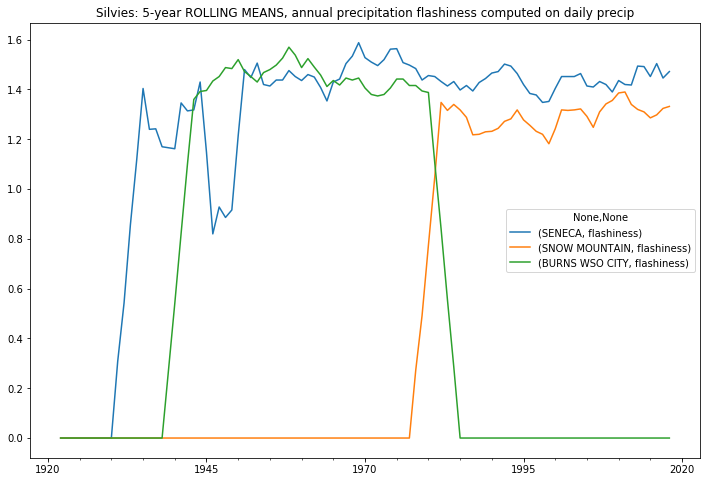

In [17]:
precipFlash = p.groupby(pd.Grouper(freq='A-DEC')).agg({flashiness})
precipFlash = precipFlash['1918':'2018'].rolling(5).mean()
precipFlash.plot(figsize=(12,8))
plt.title(shedName + ': 5-year ROLLING MEANS, annual precipitation flashiness computed on daily precip')

plt.savefig('charts/' + shedName + 'PrecipitationFlashinessRolling.png',bbox_inches='tight')

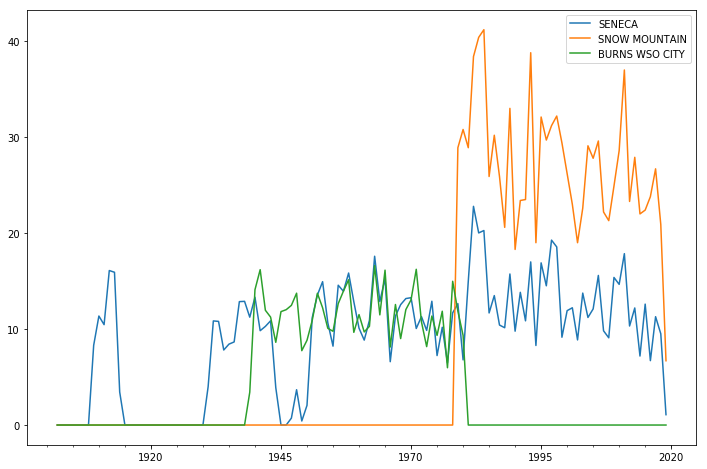

In [21]:
pgroup.plot(figsize=(12,8))
plt.savefig('charts/' + shedName + '_water_year_precip.png',bbox_inches='tight')

## Precip from CHIRPS via Earth Engine

This dataset is only available from 1981 on. If you are signed in as Google Earth Engine developer, you can get average yearly rainfall for a geometry, and export a csv to your drive.

IF YOU ARE NOT USING CHIRPS YOU SHOULD SKIP THIS SECTION




In [33]:
# #example from Catherine Creek in Oregon, processing a kind of awkward csv

# chirps = chirps.transpose()
# chirps.dtypes
# chirps['CHIRPS'] = (chirps[0])/(25.4) #convert mm to inches
# chirps.info()

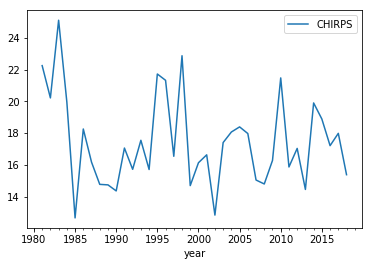

In [77]:
# chirps.drop(chirps.tail(1).index,inplace=True)
# chirps.drop(chirps.head(1).index,inplace=True)
chirps = pd.read_excel('csv/SenecaCHIRPS.xls')

chirps.set_index('year', inplace=True)
chirps.columns = ['CHIRPS']
chirps.index = pd.to_datetime(chirps.index, format='%Y')
chirps.plot()

In [78]:
chirps.index = chirps.index.shift(9, freq='M')
# chirps = chirps.index.shift(1, freq='D')
# chirps.index = chirps.index.shift(1, freq='D')
chirps


,CHIRPS
year,
1981-09-30,22.255838
1982-09-30,20.221028
1983-09-30,25.117312
1984-09-30,19.960701
1985-09-30,12.655280
1986-09-30,18.260954
1987-09-30,16.172207
1988-09-30,14.770194
1989-09-30,14.738321


In [66]:
chirps.dtypes

AttributeError: 'DatetimeIndex' object has no attribute 'dtypes'

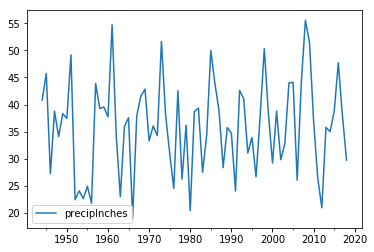

In [28]:
#replace 0s with NaN, partial years (e.g. < 14 inches) so we can get mean of rows, rename as df
df = pgroup.mask(pgroup < 14)
df['precipInches'] = df.mean(axis=1)
df = df.drop(bestgauges, axis=1)
df = df['1944':'2018']
df.plot()

In [40]:
chirps

,CHIRPS
year,
1981-01-01,22.255838
1982-01-01,20.221028
1983-01-01,25.117312
1984-01-01,19.960701
1985-01-01,12.655280
1986-01-01,18.260954
1987-01-01,16.172207
1988-01-01,14.770194
1989-01-01,14.738321


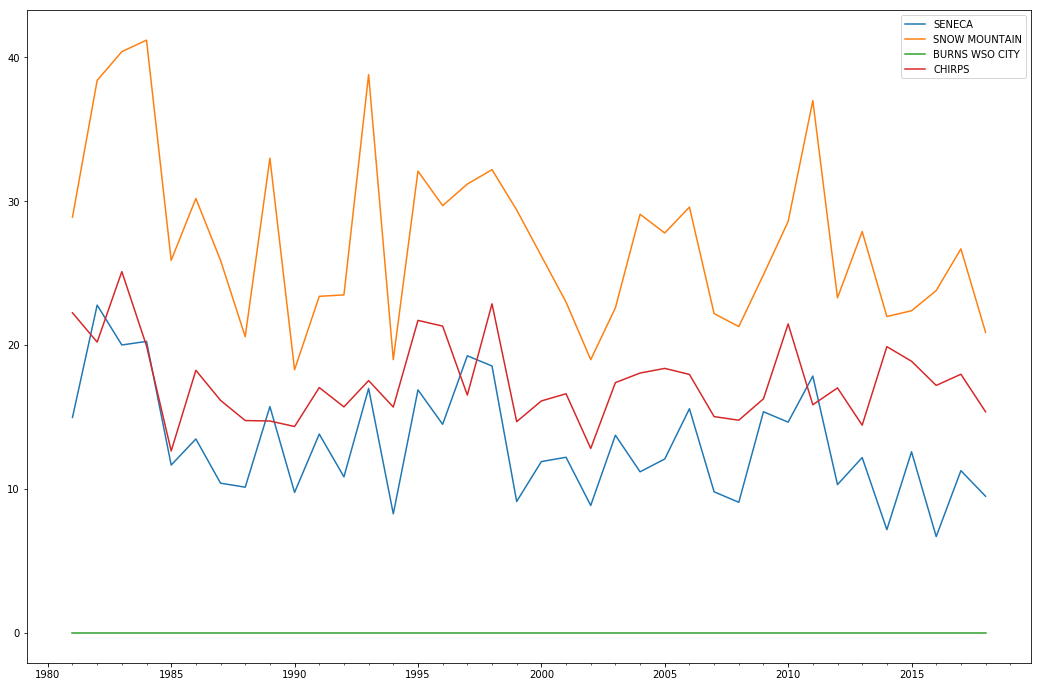

In [79]:
# now we have the same index, and can compare to CHIRPS to gauges
merged = pgroup.join(chirps, how='inner')
merged.plot(figsize=(18,12))

In [76]:
merged

,SENECA,SNOW MOUNTAIN,BURNS WSO CITY,CHIRPS
1902-09-30,0.00,0.0,0.0,NaN
1903-09-30,0.00,0.0,0.0,NaN
1904-09-30,0.00,0.0,0.0,NaN
1905-09-30,0.00,0.0,0.0,NaN
1906-09-30,0.00,0.0,0.0,NaN
1907-09-30,0.00,0.0,0.0,NaN
1908-09-30,0.00,0.0,0.0,NaN
1909-09-30,8.31,0.0,0.0,NaN
1910-09-30,11.36,0.0,0.0,NaN
1911-09-30,10.46,0.0,0.0,NaN


In [91]:
782658/9.51

82298.42271293375

In [ ]:
chirps = merged['1981':'2018']
chirps = chirps.drop(bestgauges, axis=1)
merged = merged.drop('CHIRPS', axis=1)
merged=merged['1960':'1980']
merged['CHIRPS'] = merged.mean(axis=1)
merged = merged.drop(bestgauges, axis=1)
precip = pd.concat([merged,chirps], axis=0)
precip.columns=['rainfall']

## End CHIRPS section

In [29]:
#merge precip with streamflow
df = df.merge(annualflows, left_index=True, right_index=True)

C:\Users\Peter\Anaconda3\lib\site-packages\pandas\core\reshape\merge.py:544: UserWarning: merging between different levels can give an unintended result (1 levels on the left, 2 on the right)
  warnings.warn(msg, UserWarning)


In [32]:
df.columns = ['precipInches','Altoona']
df


,precipInches,Altoona
1944-12-31,40.860000,398770.00
1945-12-31,45.750000,474375.00
1946-12-31,27.270000,119697.80
1947-12-31,38.800000,289449.00
1948-12-31,34.080000,283108.80
1949-12-31,38.330000,263279.00
1950-12-31,37.460000,188308.00
1951-12-31,49.170000,733800.00
1952-12-31,22.455000,143764.90
1953-12-31,24.096667,7536.10


In [37]:
#get numbers in acre feet
df['flowAF']= (df['Altoona']*60*60*24)/(208*208)
#get rolling mean
df['flowRolling'] = df['flowAF'].rolling(7).mean()
#convert precip in inches to acre-feet, and rolling mean
df['precipAF'] = (df['precipInches']*acres)/12
df['precipRolling'] = df['precipInches'].rolling(7).mean()
#runoff ratio
df['runoffRatio'] = df['flowAF']/df['precipAF']
df['ratioRolling'] = df['runoffRatio'].rolling(7).mean()

df.to_csv('csv/' + shedName + '.csv') #save it
df.describe()

,precipInches,Altoona,flowAF,flowRolling,precipAF,precipRolling,runoffRatio,ratioRolling
count,75.000000,75.000000,7.500000e+01,69.000000,7.500000e+01,69.000000,75.000000,69.000000
mean,35.903289,280104.763200,5.593808e+05,557099.117829,2.293454e+06,35.738944,0.225203,0.224311
std,8.594973,177809.027694,3.550920e+05,129124.792567,5.490354e+05,2.889723,0.106939,0.045450
min,19.113333,7536.100000,1.504990e+04,231941.012257,1.220934e+06,28.444524,0.009777,0.108518
25%,29.496667,143274.070000,2.861243e+05,456319.371302,1.884208e+06,34.511429,0.147617,0.193040
50%,36.880000,263279.000000,5.257791e+05,576191.808221,2.355845e+06,35.502619,0.226699,0.228222
75%,40.961667,372944.700000,7.447860e+05,637739.343829,2.616577e+06,37.507143,0.302805,0.256571
max,55.546667,788954.000000,1.575574e+06,840959.568259,3.548247e+06,43.141905,0.466561,0.310603


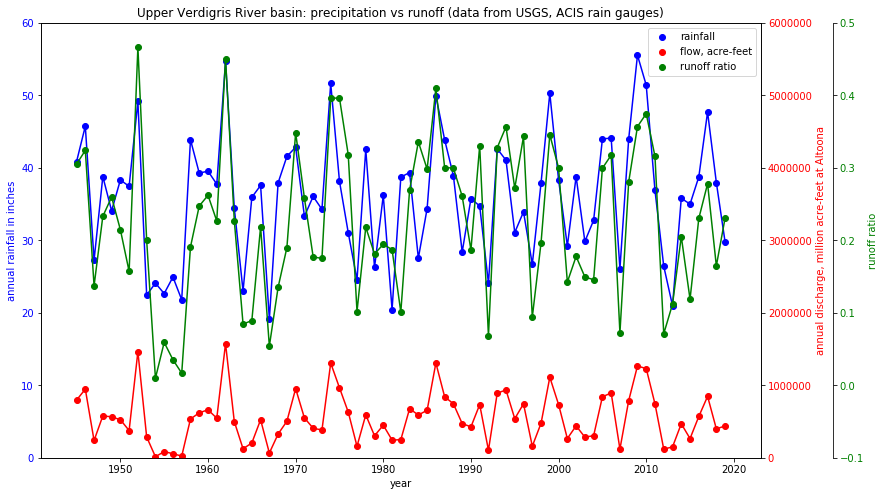

In [41]:
#chart with 3 y axes
def make_patch_spines_invisible(ax):
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)


#make lists of each series        
y1 = list(df['precipInches'])
y2 = list(df['flowAF'])
y3 = list(df['runoffRatio'])
x = list(df.index)

fig, host = plt.subplots(figsize=(16,8))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(x, y1, "b-", label="rainfall, acre-feet")
p1 = host.scatter(x, y1, c="b")

p2, = par1.plot(x, y2, "r-", label="flow, acre-feet")
p2 = par1.scatter(x, y2, c="r")

p3, = par2.plot(x, y3, "g-", label="runoff ratio")
p3 = par2.scatter(x, y3, c="g")


# host.set_xlim(0, 2)
host.set_ylim(0, 60)
par1.set_ylim(0, 6000000)
par2.set_ylim(-.1, .5)

host.set_xlabel("year")
host.set_ylabel("annual rainfall in inches")
par1.set_ylabel("annual discharge, million acre-feet at Altoona")
par2.set_ylabel("runoff ratio")

for tl in host.get_yticklabels():
    tl.set_color('b')
for tl in par1.get_yticklabels():
    tl.set_color('r')
for tl in par2.get_yticklabels():
    tl.set_color('g')
host.yaxis.label.set_color('b')
par1.yaxis.label.set_color('r')
par2.yaxis.label.set_color('g')

host.legend((p1,p2,p3), ('rainfall', 'flow, acre-feet', 'runoff ratio'))
plt.title(shedName + ' River basin: precipitation vs runoff (data from USGS, ACIS rain gauges)')

plt.savefig('charts/' + shedName + '.png',bbox_inches='tight')

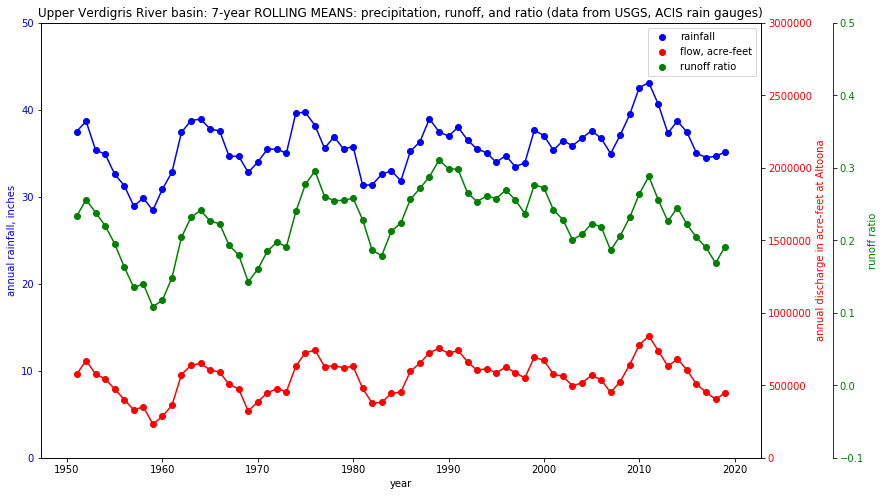

In [44]:
#rolling means

#make lists of each series        
y1 = list(df['precipRolling'])
y2 = list(df['flowRolling'])
y3 = list(df['ratioRolling'])
x = list(df.index)

fig, host = plt.subplots(figsize=(16,8))
fig.subplots_adjust(right=0.75)

par1 = host.twinx()
par2 = host.twinx()

# Offset the right spine of par2.  The ticks and label have already been
# placed on the right by twinx above.
par2.spines["right"].set_position(("axes", 1.1))
# Having been created by twinx, par2 has its frame off, so the line of its
# detached spine is invisible.  First, activate the frame but make the patch
# and spines invisible.
make_patch_spines_invisible(par2)
# Second, show the right spine.
par2.spines["right"].set_visible(True)

p1, = host.plot(x, y1, "b-", label="rainfall, acre-feet")
p1 = host.scatter(x, y1, c="b")

p2, = par1.plot(x, y2, "r-", label="flow, acre-feet")
p2 = par1.scatter(x, y2, c="r")

p3, = par2.plot(x, y3, "g-", label="runoff ratio")
p3 = par2.scatter(x, y3, c="g")

# adjust y scales so that charts are not on top of each other
# host.set_xlim(0, 2)
host.set_ylim(0, 50)
par1.set_ylim(0, 3000000)
par2.set_ylim(-.1, .5)

host.set_xlabel("year")
host.set_ylabel("annual rainfall, inches")
par1.set_ylabel("annual discharge in acre-feet at Altoona")
par2.set_ylabel("runoff ratio")

for tl in host.get_yticklabels():
    tl.set_color('b')
for tl in par1.get_yticklabels():
    tl.set_color('r')
for tl in par2.get_yticklabels():
    tl.set_color('g')
host.yaxis.label.set_color('b')
par1.yaxis.label.set_color('r')
par2.yaxis.label.set_color('g')

host.legend((p1,p2,p3), ('rainfall', 'flow, acre-feet', 'runoff ratio'))
plt.title(shedName + ': 7-year ROLLING MEANS: runoff, precipitation, and ratio (data from USGS, ACIS rain gauges)')

plt.savefig('charts/' + shedName + 'Rolling.png',bbox_inches='tight')